In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import math

In [ ]:
train_data1 = scipy.io.loadmat('/content/drive/My Drive/stat-learning/train_class1.mat')
train_data1 = train_data1['x']

In [ ]:
train_data0 = scipy.io.loadmat('/content/drive/My Drive/stat-learning/train_class0.mat')
train_data0 = train_data0['x']

**SPLITTING VALIDATION AND TRAINING DATA**

In [ ]:
validation_indices_0 = np.random.choice(2000,size=500,replace=False)
validation_indices_1 = np.random.choice(2000,size=500,replace=False)
train_indices_0 =  [i for i in range(2000) if i not in validation_indices_0]
train_indices_1 = [i for i in range(2000) if i not in validation_indices_1]

In [ ]:
train_data_0 = train_data0[train_indices_0,:]
train_data_1 = train_data1[train_indices_1,:]
validation_data_0 = train_data0[validation_indices_0,:]
validation_data_1 = train_data1[validation_indices_1,:]
print(train_data_0.shape)
print(train_data_1.shape)
print(validation_data_0.shape)
print(validation_data_1.shape)

(1500, 2)
(1500, 2)
(500, 2)
(500, 2)


In [ ]:
train_data = np.vstack((train_data_0,train_data_1))
train_labels = [0]*1500
train_labels_1 =  [1]*1500
train_labels.extend(train_labels_1)
validation_data = np.vstack((validation_data_0,validation_data_1))
validation_labels = [0]*500
validation_labels_1 =  [1]*500
validation_labels.extend(validation_labels_1)

**NORMALIZATION OF FEATURES**

In [ ]:
N= train_data.shape[0]
mean = np.mean(train_data,axis=0)[np.newaxis,:]
std_dev = np.sqrt(np.sum(np.square((train_data-mean)),axis=0)/(N-1))[np.newaxis,:]


In [ ]:
print(mean)

[[1.54106257 3.13389838]]


In [ ]:
train_data_normal = np.divide((train_data-mean),std_dev,out=np.zeros_like(train_data-mean,dtype=np.float64),where=std_dev!=0)

In [ ]:
val_data_normal = np.divide((validation_data-mean),std_dev,out=np.zeros_like(validation_data-mean,dtype=np.float64),where=std_dev!=0)

In [ ]:
test_data_1 = scipy.io.loadmat('/content/drive/My Drive/stat-learning/test_class1.mat')
test_data_1 = test_data_1['x']

In [ ]:
test_data_0 = scipy.io.loadmat('/content/drive/My Drive/stat-learning/test_class0.mat')
test_data_0 = test_data_0['x']

In [ ]:
test_data = np.vstack((test_data_0,test_data_1))
test_labels = [0]*1000
test_labels_1 = [1]*1000
test_labels.extend(test_labels_1)
print(test_data.shape)

(2000, 2)


In [ ]:
test_data_normal = np.divide((test_data-mean),std_dev,out=np.zeros_like(test_data-mean,dtype=np.float64),where=std_dev!=0)

**TRAINING NETWORK**

In [ ]:
def get_acc(Val_X,Val_labels,W1,b1,w2,b2):
    yi_ = np.asarray(Val_labels)[np.newaxis,:]
    a1 = np.matmul(W1,Val_X.T) + b1
    h1 = np.maximum(a1,0)
    a2 = np.matmul(w2,h1) + b2
    yi = np.reciprocal(1+np.exp(-a2))
    loss = np.sum(np.square(yi-yi_),axis=1)
    pred_label =np.where(yi>=0.5,1,0)
    acc = 1-(np.sum(np.abs(pred_label-yi_))/Val_X.shape[0])
    return loss, acc

In [ ]:
def plot_learning_curve(train_acc_list,val_acc_list,test_acc_list):
  train_acc_list = np.convolve(train_acc_list, np.ones(10)/10, mode='valid').tolist()
  val_acc_list = np.convolve(val_acc_list, np.ones(10)/10, mode='valid').tolist()
  test_acc_list = np.convolve(test_acc_list, np.ones(10)/10, mode='valid').tolist()
  plt.figure(figsize=(12,6))
  plt.title("Learning Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.plot([i for i in range(len(train_acc_list))],train_acc_list, color='red',label='training accuracy')
  plt.plot([i for i in range(len(val_acc_list))],val_acc_list, color= 'green',label='validation accuracy')
  plt.plot([i for i in range(len(test_acc_list))],test_acc_list, color = 'blue',label='testing accuracy')
  plt.xticks(np.arange(0, len(train_acc_list), 50))
  plt.legend()
  plt.show()


In [ ]:
def train_network(X,Val_X,X_labels,Val_labels,test_data,test_labels,nh=8,epochs=200):
  reg = 0.001
  rate = 3
  W1 = np.random.uniform(low = 0,high = 2/math.sqrt(2), size=(nh,2))
  b1 = np.zeros((nh,1))
  w2 = np.random.uniform(low = -2/math.sqrt(nh), high = 2/math.sqrt(nh), size =(1,nh))
  b2 = np.zeros((1,))
  yi_ = np.asarray(X_labels)[np.newaxis,:]
  prev_dW1 = 0
  prev_db1 = np.zeros((nh,))
  prev_dw2 = 0
  prev_db2 = 0
  train_acc_list = []
  val_acc_list = []
  test_acc_list = []
  for num in range(epochs):
    a1 = np.matmul(W1,X.T) + b1
    h1 = np.maximum(a1,0)
    a2 = np.matmul(w2,h1) + b2
    yi = np.reciprocal(1+np.exp(-a2))
    loss = np.sum(np.square(yi-yi_),axis=1)
    pred_label =np.where(yi>=0.5,1,0)
    acc = 1-(np.sum(np.abs(pred_label-yi_))/X.shape[0])
    print(f" epoch {num}: {loss}")
    print(f"accuracy : {acc}")
    train_acc_list.append(acc)
    val_loss, val_acc = get_acc(Val_X,Val_labels,W1,b1,w2,b2)
    print(f"val loss : {val_loss}")
    print(f"val accuracy : {val_acc}")
    val_acc_list.append(val_acc)
    test_loss, test_acc = get_acc(test_data,test_labels,W1,b1,w2,b2)
    print(f"test loss : {test_loss}")
    print(f"test accuracy : {test_acc}")
    test_acc_list.append(test_acc)
    da2 = yi-yi_
    da2 = da2*yi
    da2 = da2*(1-yi)
    #print(f"da2 : {da2.shape}")
    db2 = np.mean(da2,axis=1)
    #print(f"db2 : {db2.shape}")
    dw2 = np.mean(h1*da2, axis=1)
    #print(f"dw2 : {dw2.shape}")
    dh1 = np.matmul(w2.T,da2)
    #print(f"dh1 : {dh1.shape}")

    da1 = dh1*(np.where(h1>0,1,0))
    #print(f"da1 : {da1.shape}")
    db1 = np.mean(da1,axis=1)
    #print(f"db1 : {db1.shape}")
    temp1 = np.mean(da1*(X[:,0].T),axis=1)[:,np.newaxis]
    temp2 = np.mean(da1*(X[:,1].T),axis=1)[:,np.newaxis]
    dW1 = np.hstack((temp1,temp2))
    #print(f"dW1 : {dW1.shape}")

    w2 = w2 - rate*(dw2) -0.9*prev_dw2 #-reg*w2
    #print(w2.shape)
    b2 = b2 - rate*(db2) -0.9*prev_db2
    #print(b2.shape)
    W1 = W1 - rate*(dW1) -0.9*prev_dW1#-reg*W1
    #print(W1.shape)
    b1 = b1 - rate*(db1[:,np.newaxis]) -0.9*(prev_db1[:,np.newaxis])
    #print(b1.shape)

    prev_dW1 = dW1
    prev_db1 = db1
    prev_dw2 = dw2
    prev_db2 = db2

    if num==0:
      val_loss_prev =val_loss
    if num%50==0 and num!=0:
      diff = (val_loss-val_loss_prev)/50
      if diff >= -0.00001:
        return train_acc_list,val_acc_list,test_acc_list
      else:
        val_loss_prev = val_loss
  return train_acc_list,val_acc_list,test_acc_list






**NH = 10**

In [ ]:
train_acc_list, val_acc_list, test_acc_list = train_network(train_data_normal,val_data_normal,train_labels,validation_labels,test_data_normal,test_labels,nh=10,epochs=1000)

Streaming output truncated to the last 5000 lines.
test loss : [317.66449113]
test accuracy : 0.7975
 epoch 167: [498.10254484]
accuracy : 0.7803333333333333
val loss : [163.32039453]
val accuracy : 0.79
test loss : [317.01395464]
test accuracy : 0.798
 epoch 168: [497.05440717]
accuracy : 0.7813333333333333
val loss : [163.00886136]
val accuracy : 0.79
test loss : [316.34450584]
test accuracy : 0.7975
 epoch 169: [496.02429451]
accuracy : 0.781
val loss : [162.70691125]
val accuracy : 0.789
test loss : [315.70965102]
test accuracy : 0.7975
 epoch 170: [495.01622956]
accuracy : 0.7816666666666667
val loss : [162.40897458]
val accuracy : 0.79
test loss : [315.074563]
test accuracy : 0.798
 epoch 171: [494.02407259]
accuracy : 0.7823333333333333
val loss : [162.10994081]
val accuracy : 0.789
test loss : [314.44724084]
test accuracy : 0.798
 epoch 172: [493.03612446]
accuracy : 0.7826666666666666
val loss : [161.81254848]
val accuracy : 0.79
test loss : [313.83385423]
test accuracy : 0.79

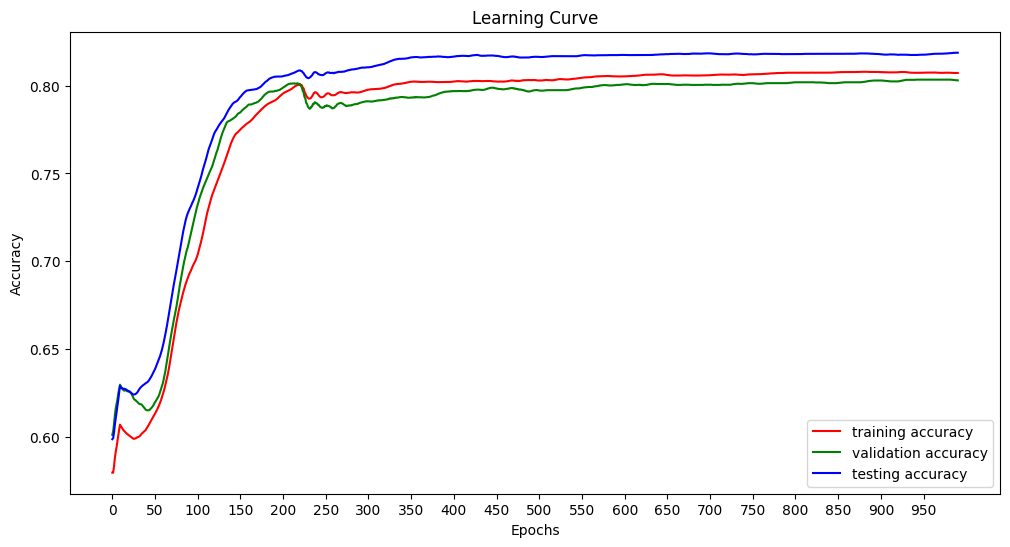

In [ ]:
plot_learning_curve(train_acc_list,val_acc_list,test_acc_list)

**NH = 8**

In [ ]:
train_acc_list, val_acc_list, test_acc_list = train_network(train_data_normal,val_data_normal,train_labels,validation_labels,test_data_normal,test_labels,nh=8,epochs=1000)

 epoch 0: [852.15053358]
accuracy : 0.5013333333333334
val loss : [275.62028096]
val accuracy : 0.501
test loss : [557.22749576]
test accuracy : 0.5005
 epoch 1: [787.03673743]
accuracy : 0.532
val loss : [255.33165122]
val accuracy : 0.548
test loss : [513.05268025]
test accuracy : 0.5425
 epoch 2: [720.10763982]
accuracy : 0.5866666666666667
val loss : [234.23029447]
val accuracy : 0.614
test loss : [467.75649984]
test accuracy : 0.608
 epoch 3: [692.34513005]
accuracy : 0.5916666666666667
val loss : [225.42549078]
val accuracy : 0.613
test loss : [449.25891001]
test accuracy : 0.617
 epoch 4: [686.90804142]
accuracy : 0.5803333333333334
val loss : [223.56131351]
val accuracy : 0.596
test loss : [445.36340736]
test accuracy : 0.6065
 epoch 5: [684.84070152]
accuracy : 0.5766666666666667
val loss : [222.71243751]
val accuracy : 0.594
test loss : [443.4160939]
test accuracy : 0.6014999999999999
 epoch 6: [683.37226636]
accuracy : 0.575
val loss : [222.08311002]
val accuracy : 0.5880000

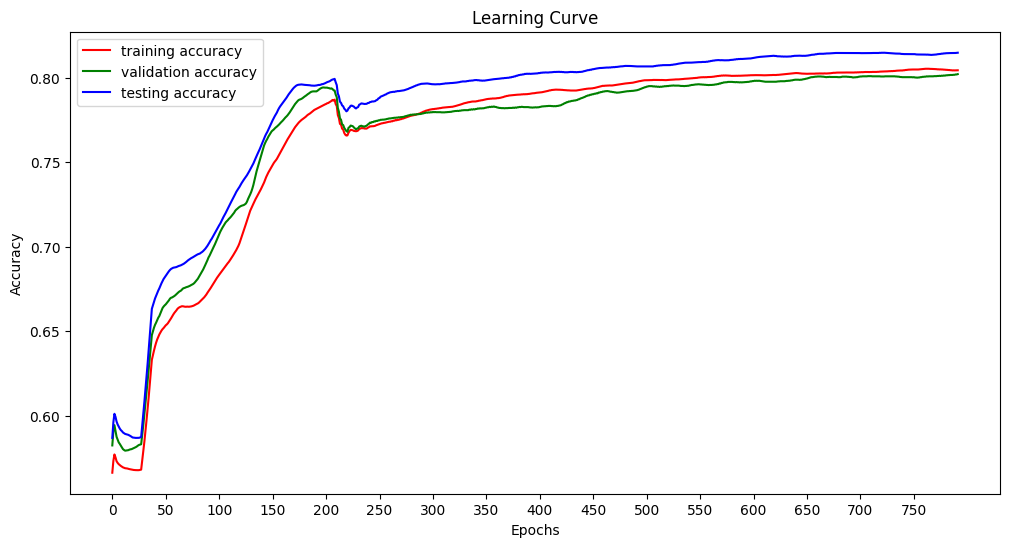

In [ ]:
plot_learning_curve(train_acc_list,val_acc_list,test_acc_list)

**NH = 6**

In [ ]:
train_acc_list, val_acc_list, test_acc_list = train_network(train_data_normal,val_data_normal,train_labels,validation_labels,test_data_normal,test_labels,nh=6,epochs=1000)

 epoch 0: [1031.25369484]
accuracy : 0.5
val loss : [338.10420101]
val accuracy : 0.5
test loss : [697.82839108]
test accuracy : 0.5
 epoch 1: [999.69304082]
accuracy : 0.44566666666666666
val loss : [327.67737405]
val accuracy : 0.44699999999999995
test loss : [675.56285348]
test accuracy : 0.4265
 epoch 2: [947.83964363]
accuracy : 0.45933333333333337
val loss : [310.99567228]
val accuracy : 0.469
test loss : [639.13314743]
test accuracy : 0.44599999999999995
 epoch 3: [873.45695106]
accuracy : 0.5066666666666666
val loss : [287.89955017]
val accuracy : 0.514
test loss : [586.90563916]
test accuracy : 0.49250000000000005
 epoch 4: [776.77520272]
accuracy : 0.5236666666666667
val loss : [258.19408775]
val accuracy : 0.524
test loss : [518.99464339]
test accuracy : 0.512
 epoch 5: [729.35532909]
accuracy : 0.5846666666666667
val loss : [243.04944965]
val accuracy : 0.5880000000000001
test loss : [484.31464322]
test accuracy : 0.591
 epoch 6: [718.2834124]
accuracy : 0.6103333333333334


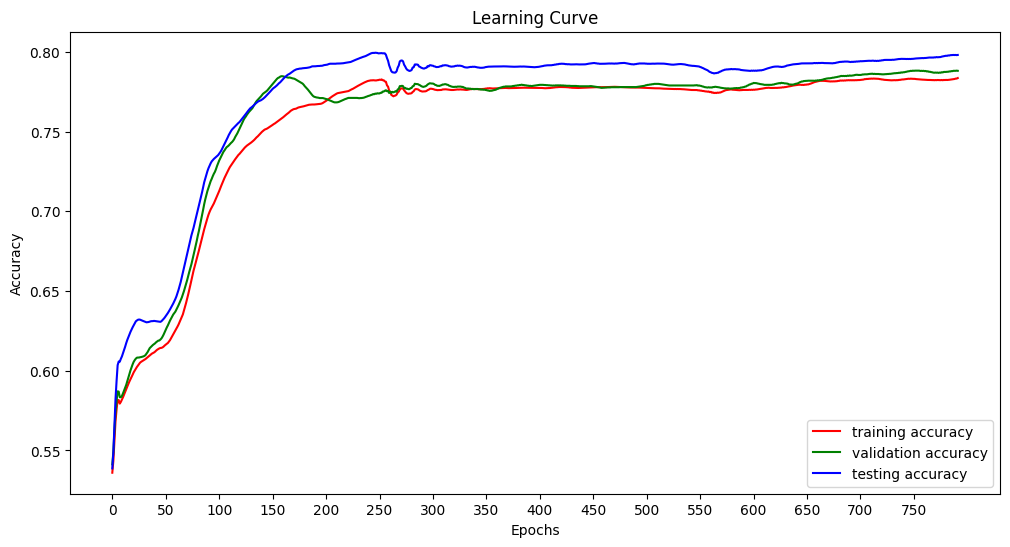

In [ ]:
plot_learning_curve(train_acc_list,val_acc_list,test_acc_list)

**NH = 4**

In [ ]:
train_acc_list, val_acc_list, test_acc_list = train_network(train_data_normal,val_data_normal,train_labels,validation_labels,test_data_normal,test_labels,nh=4,epochs=1000)

 epoch 0: [776.67568972]
accuracy : 0.5953333333333333
val loss : [251.97059409]
val accuracy : 0.598
test loss : [504.31019555]
test accuracy : 0.61
 epoch 1: [722.26206526]
accuracy : 0.5883333333333334
val loss : [234.35735265]
val accuracy : 0.612
test loss : [466.18902711]
test accuracy : 0.611
 epoch 2: [693.84914377]
accuracy : 0.5900000000000001
val loss : [224.69606288]
val accuracy : 0.615
test loss : [446.07952646]
test accuracy : 0.617
 epoch 3: [688.48397047]
accuracy : 0.5800000000000001
val loss : [222.53066569]
val accuracy : 0.598
test loss : [441.38486734]
test accuracy : 0.6014999999999999
 epoch 4: [685.37648991]
accuracy : 0.5746666666666667
val loss : [221.18494371]
val accuracy : 0.594
test loss : [438.13480896]
test accuracy : 0.596
 epoch 5: [683.44315756]
accuracy : 0.5740000000000001
val loss : [220.33393921]
val accuracy : 0.598
test loss : [435.99679669]
test accuracy : 0.597
 epoch 6: [682.13428906]
accuracy : 0.5736666666666667
val loss : [219.77372952]
v

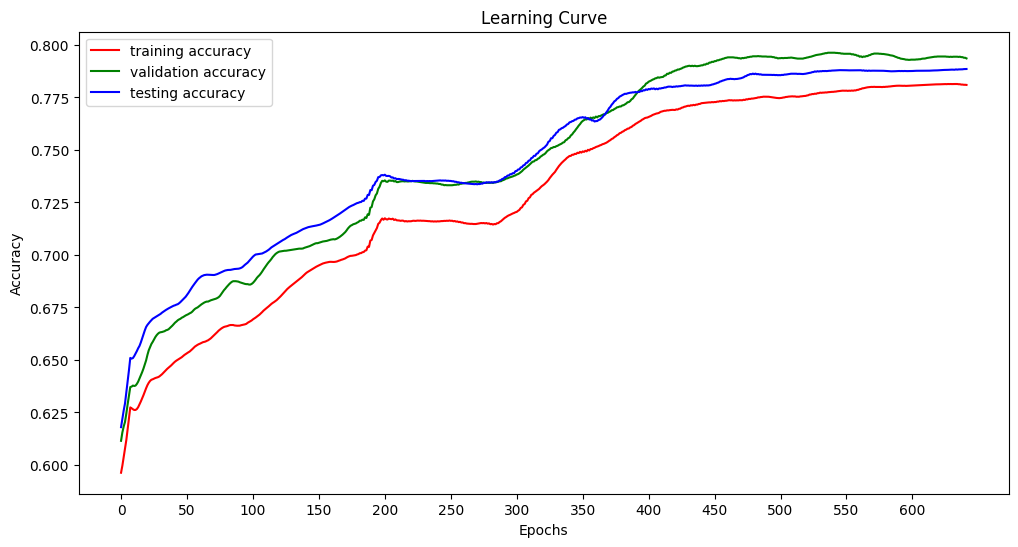

In [ ]:
plot_learning_curve(train_acc_list,val_acc_list,test_acc_list)

**NH = 2**

In [ ]:
train_acc_list, val_acc_list, test_acc_list = train_network(train_data_normal,val_data_normal,train_labels,validation_labels,test_data_normal,test_labels,nh=2,epochs=1000)

 epoch 0: [854.94535815]
accuracy : 0.4766666666666667
val loss : [284.6564466]
val accuracy : 0.472
test loss : [575.34908865]
test accuracy : 0.46799999999999997
 epoch 1: [811.99851625]
accuracy : 0.44199999999999995
val loss : [271.30289913]
val accuracy : 0.43000000000000005
test loss : [545.13613754]
test accuracy : 0.41600000000000004
 epoch 2: [776.34337879]
accuracy : 0.396
val loss : [260.28092221]
val accuracy : 0.38
test loss : [519.78011043]
test accuracy : 0.37
 epoch 3: [761.01759378]
accuracy : 0.45199999999999996
val loss : [255.49474887]
val accuracy : 0.45299999999999996
test loss : [508.56648989]
test accuracy : 0.4525
 epoch 4: [752.80503446]
accuracy : 0.478
val loss : [252.76665287]
val accuracy : 0.47
test loss : [502.58365918]
test accuracy : 0.47550000000000003
 epoch 5: [746.76471771]
accuracy : 0.5483333333333333
val loss : [250.71590956]
val accuracy : 0.5409999999999999
test loss : [498.27819823]
test accuracy : 0.5509999999999999
 epoch 6: [742.11433974]


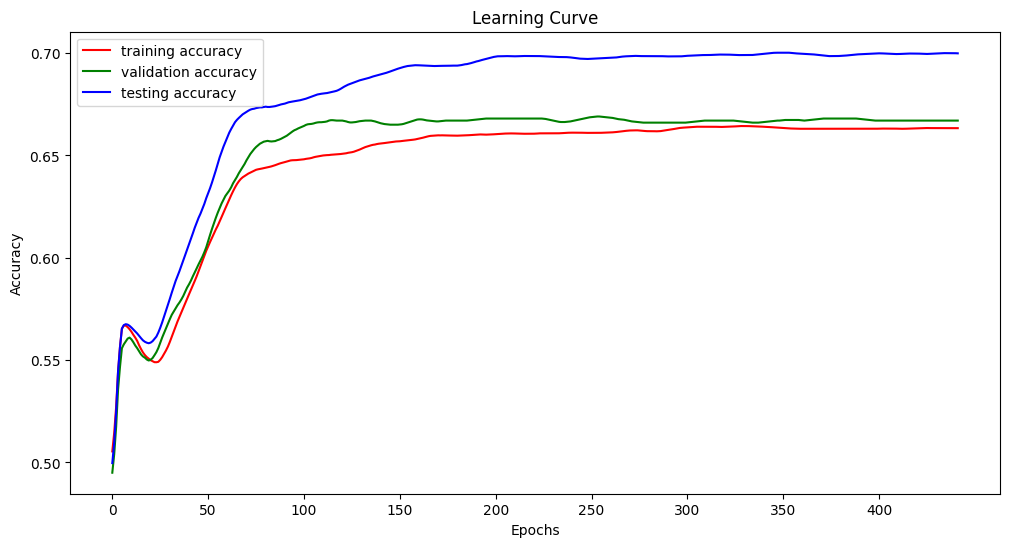

In [ ]:
plot_learning_curve(train_acc_list,val_acc_list,test_acc_list)

**DATA SCATTER PLOT**

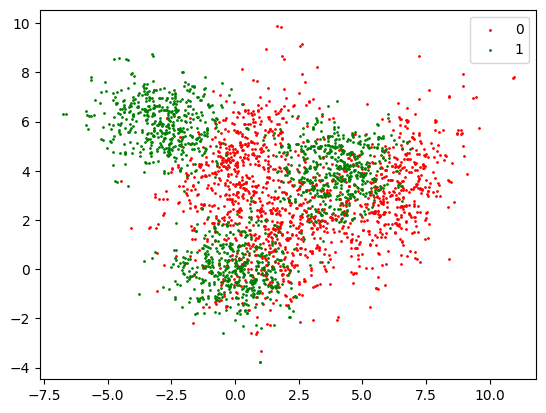

In [ ]:

plt.scatter(train_data_0[:,0], train_data_0[:,1], s=1,c='r',label='0')
plt.scatter(train_data_1[:,0], train_data_1[:,1],s=1, c='g',label='1')
plt.legend()
plt.show()

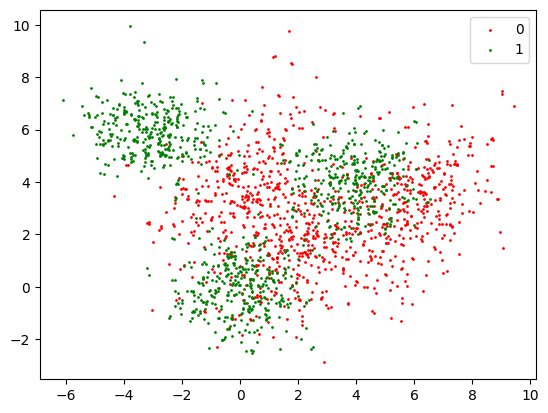

In [ ]:
plt.scatter(test_data_0[:,0], test_data_0[:,1], s=1,c='r',label='0')
plt.scatter(test_data_1[:,0], test_data_1[:,1],s=1, c='g',label='1')
plt.legend()
plt.show()